In [1]:
#IMPORT
import json
import pandas as pd
import heapq, random
from heapq import nlargest
from twitter import *
import sys
import time
import operator
from twitter.api import TwitterHTTPError
from urllib.error import URLError
from http.client import BadStatusLine
from itertools import islice
# This will let us create new partial
# functions with arguments set to 
# certain values.
from functools import partial
# This was maxint.
# There is no longer a maxint (in Python 3)
from sys import maxsize
import matplotlib.pyplot as plt
import networkx as nx
import json
import community

In [2]:
#########################################################################################################################
#LOADING THE TOKENS
# Loading my authentication tokens
with open('auth_dict.json','r') as f:
    twtr_auth = json.load(f)

# To make it more readable, lets store
# the OAuth credentials in strings first.
CONSUMER_KEY = twtr_auth['consumer_key']
CONSUMER_SECRET = twtr_auth['consumer_secret']
OAUTH_TOKEN = twtr_auth['token']
OAUTH_TOKEN_SECRET = twtr_auth['token_secret']
    
# Then, we store the OAuth object in "auth"
auth = OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                           CONSUMER_KEY, CONSUMER_SECRET)
# Notice that there are four tokens - you need to create these in the
# Twitter Apps dashboard after you have created your own "app".

# We now create the twitter search object.
t = Twitter(auth=auth)

In [3]:
def make_twitter_request(twitter_api_func, max_errors=10, *args, **kw):
    # A nested helper function that handles common HTTPErrors. Return an updated
    # value for wait_period if the problem is a 500 level error. Block until the
    # rate limit is reset if it's a rate limiting issue (429 error). Returns None
    # for 401 and 404 errors, which requires special handling by the caller.
    def handle_twitter_http_error(e, wait_period=2, sleep_when_rate_limited=True):
        if wait_period > 3600: # Seconds
            print('Too many retries. Quitting.', file=sys.stderr)
            raise e
        if e.e.code == 401:
            return None
        elif e.e.code == 404:
            print('Encountered 404 Error (Not Found)', file=sys.stderr)
            return None
        elif e.e.code == 429:
            print('Encountered 429 Error (Rate Limit Exceeded)', file=sys.stderr)
            if sleep_when_rate_limited:
                print("Retrying in 15 minutes...ZzZ...", file=sys.stderr)
                sys.stderr.flush()
                time.sleep(60*15 + 5)
                print('...ZzZ...Awake now and trying again.', file=sys.stderr)
                return 2
            else:
                raise e # Caller must handle the rate limiting issue
        elif e.e.code in (500, 502, 503, 504):
            print('Encountered %i Error. Retrying in %i seconds' % (e.e.code, wait_period), file=sys.stderr)
            time.sleep(wait_period)
            wait_period *= 1.5
            return wait_period
        else:
            raise e

    # End of nested helper function

    wait_period = 2
    error_count = 0
    while True:
        try:
            return twitter_api_func(*args, **kw)
        except TwitterHTTPError as e:
            error_count = 0
            wait_period = handle_twitter_http_error(e, wait_period)
            if wait_period is None:
                return
        except URLError as e:
            error_count += 1
            print("URLError encountered. Continuing.", file=sys.stderr)
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise
        except BadStatusLine as e:
            error_count += 1
            print >> sys.stderr, "BadStatusLine encountered. Continuing."
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise
                


In [4]:
######################################################################################################################
#######################################################################################################################
##
def get_friends_followers_ids(twitter_api, screen_name=None, user_id=None,
                                friends_limit=maxsize, followers_limit=maxsize):
    # Must have either screen_name or user_id (logical xor)
    assert (screen_name != None) != (user_id != None), \
    "Must have screen_name or user_id, but not both"
    
    # You can also do this with a function closure.
    get_friends_ids = partial(make_twitter_request, twitter_api.friends.ids,
                                count=5000)
    get_followers_ids = partial(make_twitter_request, twitter_api.followers.ids,
                                count=5000)
    friends_ids, followers_ids = [], []
    for twitter_api_func, limit, ids, label in [
            [get_friends_ids, friends_limit, friends_ids, "friends"],
            [get_followers_ids, followers_limit, followers_ids, "followers"]
            ]:
        #LOOK HERE! This little line is important.
        if limit == 0: continue
        cursor = -1
        while cursor != 0:
            # Use make_twitter_request via the partially bound callable...
            if screen_name:
                response = twitter_api_func(screen_name=screen_name, cursor=cursor)
            else: # user_id
                response = twitter_api_func(user_id=user_id, cursor=cursor)
            if response is not None:
                ids += response['ids']
                cursor = response['next_cursor']
            print('Fetched {0} total {1} ids for {2}'.format(len(ids),
                    label, (user_id or screen_name), file=sys.stderr))
            if len(ids) >= limit or response is None:
                break
    print("---------------------------------------------------------------------------------------------------")
    # Do something useful with the IDs, like store them to disk...
    return friends_ids[:friends_limit], followers_ids[:followers_limit]

In [5]:
screen_name = "ThePresObama"
########################################################################################################################
########################################################################################################################
friends_ids, followers_ids = get_friends_followers_ids(t,
                                screen_name="ThePresObama",
                                friends_limit=10,
                                followers_limit=10)
dictionary = {}
dictionary['1'] = friends_ids
print("---------------------------------------------------------------------------------------------------")
print("\nFriend's List:")
print(friends_ids,"\n")
#print("---------------------------------------------------------------------------------------------------")
print("\nFollower's List:\n")
print(followers_ids)
print("---------------------------------------------------------------------------------------------------")
#################################################################################################################3
########################################################################################################3
for x in friends_ids:
    friends_ids, followers_ids = get_friends_followers_ids(t,
                                user_id=x,
                                friends_limit=10,
                                followers_limit=10)
    dictionary[x] = friends_ids
    mergedlist = friends_ids  
   # print('Fetched {0} total {1} ids for {2}'.format(len(ids),label, (user_id or screen_name), file=sys.stderr))
    print("---------------------------------------------------------------------------------------------------")
    print("\nFriend's List:")
    print(friends_ids,"\n")
    #print("---------------------------------------------------------------------------------------------------")
    print("\nFollower's List:\n")
    print(followers_ids)
    print("---------------------------------------------------------------------------------------------------")
     
#################################################################################################################3
########################################################################################################3

for y in friends_ids:
    friends_ids, followers_ids = get_friends_followers_ids(t,
                                user_id=y,
                                friends_limit=5,
                                followers_limit=5)
    dictionary[y] = friends_ids
    print("---------------------------------------------------------------------------------------------------")
    print("\nFriend's List:")
    print(friends_ids,"\n")
    #print("---------------------------------------------------------------------------------------------------")
    print("\nFollower's List:\n")
    print(followers_ids)
    print("---------------------------------------------------------------------------------------------------")

Fetched 420 total friends ids for ThePresObama
Fetched 5000 total followers ids for ThePresObama
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------

Friend's List:
[258516777, 959923969842401280, 4273224434, 17725964, 965266179836252161, 719868757229834245, 133028836, 910492003359760384, 17560096, 230804122] 


Follower's List:

[2337643400, 789125352882831361, 967553816483655680, 972258531482071040, 14780565, 972245872456052736, 574810286, 971932316821086208, 2488798316, 3356776948]
---------------------------------------------------------------------------------------------------
Fetched 451 total friends ids for 258516777
Fetched 5000 total followers ids for 258516777
---------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------

Fetched 2414 total friends ids for 27711685
Fetched 5000 total followers ids for 27711685
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------

Friend's List:
[28032403, 3028041880, 2147593411, 950557122793787392, 903949620073467904] 


Follower's List:

[2554624312, 956168363373481984, 972310874789572608, 972310392566403073, 972308944143044608]
---------------------------------------------------------------------------------------------------
Fetched 993 total friends ids for 283783863
Fetched 5000 total followers ids for 283783863
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------

Friend's List:
[104712514, 20247218, 25776991, 177742381, 28265608] 


Follower's List:

[25419957, 81356253, 535

Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...
...ZzZ...Awake now and trying again.


Fetched 4205 total friends ids for 13073662
Fetched 5000 total followers ids for 13073662
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------

Friend's List:
[817413454432784384, 19951688, 21416805, 19103202, 317366517] 


Follower's List:

[433609379, 944013390, 291353842, 27141584, 2842647779]
---------------------------------------------------------------------------------------------------
Fetched 5000 total friends ids for 265169401
Fetched 5000 total followers ids for 265169401
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------

Friend's List:
[1700125602, 172145144, 381513941, 181269400, 2827266097] 


Follower's List:

[344365293, 882473312848289793, 878142152148217856, 59417118, 316879

In [6]:
df = pd.DataFrame(columns=['ID','follower1','follower2','follower3','follower4','follower5'])
df.to_csv('followers_use.csv', index=False)

# Our function
#def save_followers(fid, followers):
def save_followers(fid, follower1, follower2, follower3, follower4, follower5):
    #print ("In save_followers function---------------")
    #print (fid)
    #print (followers)
    #print ("-----------------------------------------")
    #df = pd.DataFrame([[fid, followers]], columns=['ID','followers'])
    df = pd.DataFrame([[fid, follower1, follower2, follower3, follower4, follower5]], columns=['ID','follower1','follower2','follower3','follower4','follower5'])
    with open('followers_use.csv', 'a') as f:
        df.to_csv(f,header=False, index=False)

In [7]:
def crawl_followers(twitter_api, screen_name, limit=1000000, depth=2):
    
    # Resolve the ID for screen_name and start working with IDs for consistency
    #print (screen_name)
    #print (limit)
    #print (depth)
    
    #seed_id = str(twitter_api.users.show(screen_name=screen_name)['id'])
    seed_id = twitter_api.users.show(screen_name=screen_name)['id']
    _, next_queue = get_friends_followers_ids(twitter_api, user_id=seed_id,
                        friends_limit=limit, followers_limit=limit)
    
    #print ("next_queue-----------------------")
    #print (next_queue)
    #print ("---------------------------------")
    
    # Store a seed_id => _follower_ids mapping in MongoDB
    #save_followers(seed_id, ','.join([str(x) for x in next_queue]))
    save_followers(seed_id, next_queue[0], next_queue[1], next_queue[2], next_queue[3], next_queue[4])
    
    d = 1
    # Note that in the example in the next cell,
    # we never enter this loop.
    while d < depth:
        d += 1
        # Reset the next_queue so that we can
        # start building up the next level
        # of followers-of-followers
        (queue, next_queue) = (next_queue, [])
        # Loop through the current
        # level of followers
        for fid in queue:
            _, follower_ids = get_friends_followers_ids(twitter_api, user_id=fid,
                                friends_limit=limit, followers_limit=limit)
            # Store an ID with a string recording
            # IDs of followers of the user with ID "fid"
            #save_followers(str(fid), ','.join([str(x) for x in follower_ids]))
            #save_followers(str(fid), ','.join([str(x) for x in follower_ids]))
            save_followers(fid, friends_ids[0], friends_ids[1], friends_ids[2], friends_ids[3], friends_ids[4])
            # Extending the list
            next_queue += follower_ids

In [8]:
#screen_name = "ZedShaw"
screen_name = "timesquareball"#wrong
crawl_followers(t, screen_name, depth=2, limit=10)

Fetched 18 total friends ids for 1053587856
Fetched 394 total followers ids for 1053587856
---------------------------------------------------------------------------------------------------
Fetched 73 total friends ids for 755484403996954624
Fetched 2 total followers ids for 755484403996954624
---------------------------------------------------------------------------------------------------
Fetched 1272 total friends ids for 225475343
Fetched 298 total followers ids for 225475343
---------------------------------------------------------------------------------------------------
Fetched 394 total friends ids for 1393592024
Fetched 39 total followers ids for 1393592024
---------------------------------------------------------------------------------------------------
Fetched 153 total friends ids for 852267127
Fetched 7 total followers ids for 852267127
---------------------------------------------------------------------------------------------------
Fetched 117 total friends ids for 

Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...
...ZzZ...Awake now and trying again.


Fetched 0 total friends ids for 1030319478
Fetched 0 total followers ids for 1030319478
---------------------------------------------------------------------------------------------------
Fetched 70 total friends ids for 1010457600
Fetched 9 total followers ids for 1010457600
---------------------------------------------------------------------------------------------------


In [9]:
unique_ids1 = []
with open('followers_use.csv') as csvRead:
    all_ids = []
    for line in enumerate(csvRead):
        ids = line[1].replace('\n', '')
        ids1 = ids.split(',')
        all_ids.append(ids1)
    all_ids = all_ids[1:]
    for a in all_ids:
        for b in a:
            unique_ids1.append(int(b))
    
    myset = set(unique_ids1)
    unique_ids = list(myset)

In [10]:
G = nx.Graph()
G.add_nodes_from(unique_ids)
for a in all_ids:
    fromID = a[0]
    for b in a[1:]:
        G.add_edge(int(fromID), int(b))

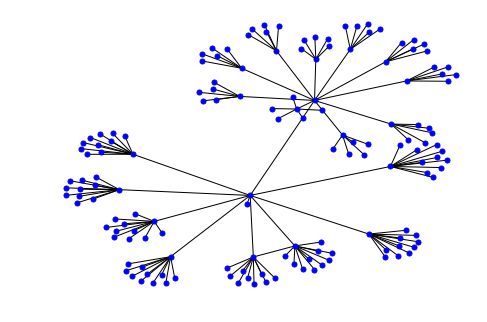

networkx.classes.graph.Graph

In [15]:
G=nx.from_dict_of_lists(dictionary)
nx.draw(G,with_labels=False,node_color="blue",node_size=25)
plt.show()
type(G)

In [19]:
json.dump(dictionary, open("text_sakshi.txt",'w'))

In [20]:
d2 = json.load(open("text_sakshi.txt"))
#d2

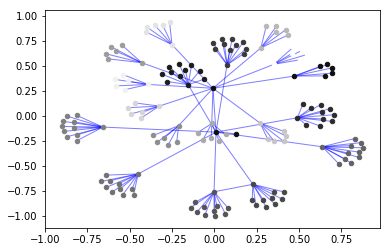

In [17]:
#better with karate_graph() as defined in networkx example.
#erdos renyi don't have true community structure
#G = nx.erdos_renyi_graph(30, 0.05)

#first compute the best partition
partition = community.best_partition(G)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count/size))


nx.draw_networkx_edges(G,pos, alpha=0.5,edge_color="blue")
plt.show()